# 大作业要求

1.大作业以2-3人为一组完成，提交材料包括PPT（最后一次课展示成果）+ 可运行的jupyter notebook，标注相应的注释并给出运行结果 + 最终的大作业报告（正文不超过5页word/pdf，附录可选不限，需组内各成员单独提交，内容为本人在课程大作业中的贡献以及对大作业问题的思考) + 提交包含分工情况及组内各成员工作量占比的表格。分工表格需组内所有成员签字确认；

2.禁止抄袭，发现雷同，所有雷同提交分数除以2；

3.写清楚大作业中的贡献和创新点，若使用开源代码和论文中的方法，在报告中必须注明（不可作为本人创新点），发现不标注引用，分数除以2。

最后一次课展示说明： 1.样例 PPT例子：https://www.sohu.com/a/166633625_642762 2.展示时间限制：展示时间为6分钟讲+2分钟同学助教老师自由提问

大作业报告：强调个人对问题的理解，以及贡献，建议增加在提问反馈之后的改进结果。

最终评分为:30%展示评分+70%大作业报告

# 问题描述

深度神经网络通常采用独立同分布(Independent-Identically)的假设进行训练，即假设测试数据分布与训练数据分布相似。然而，当用于实际任务时，这一假设并不成立，导致其性能显著下降。虽然这种性能下降对于产品推荐等宽容性大的应用是可以接受的，但在医学等宽容性小的领域使用此类系统是危险的，因为它们可能导致严重事故。理想的人工智能系统应尽可能在分布外（Out-of-Distribution）的情况下有较强的分部外泛化能力。而提高分布外泛化的关键点，就是如何让模型学习到数据中的causal feature。

一个简单的例子：以猫狗二分类为例，如果训练集中所有狗都在草地上，所有的猫都在沙发上，而测试集中所有的狗在沙发上，所有的猫在草地上，那么模型在没有测试集信息的情况下，很有可能根据训练集的信息把草地和狗联系在了一起，沙发和猫联系在了一起，当模型在测试集上测试时将会把在沙发上的狗误认为是猫。

# 数据集(Colored MNIST)

Colored MNIST是MNIST手写数字分类数据集的变体，包含有三个不同的域，每个域包含一组不相交的红色或绿色数字并分别保存为train1.pt, train2.pt, test.pt。该数据集总共包含60000个样本。 

在该数据集中，训练集和测试集之间存在Out-of-Distribution情况，color feature和数字产生了spurious correlation，即虚假的因果关系。从直观上来说，数字的形状为causal feature，数字的颜色为non-causal feature。

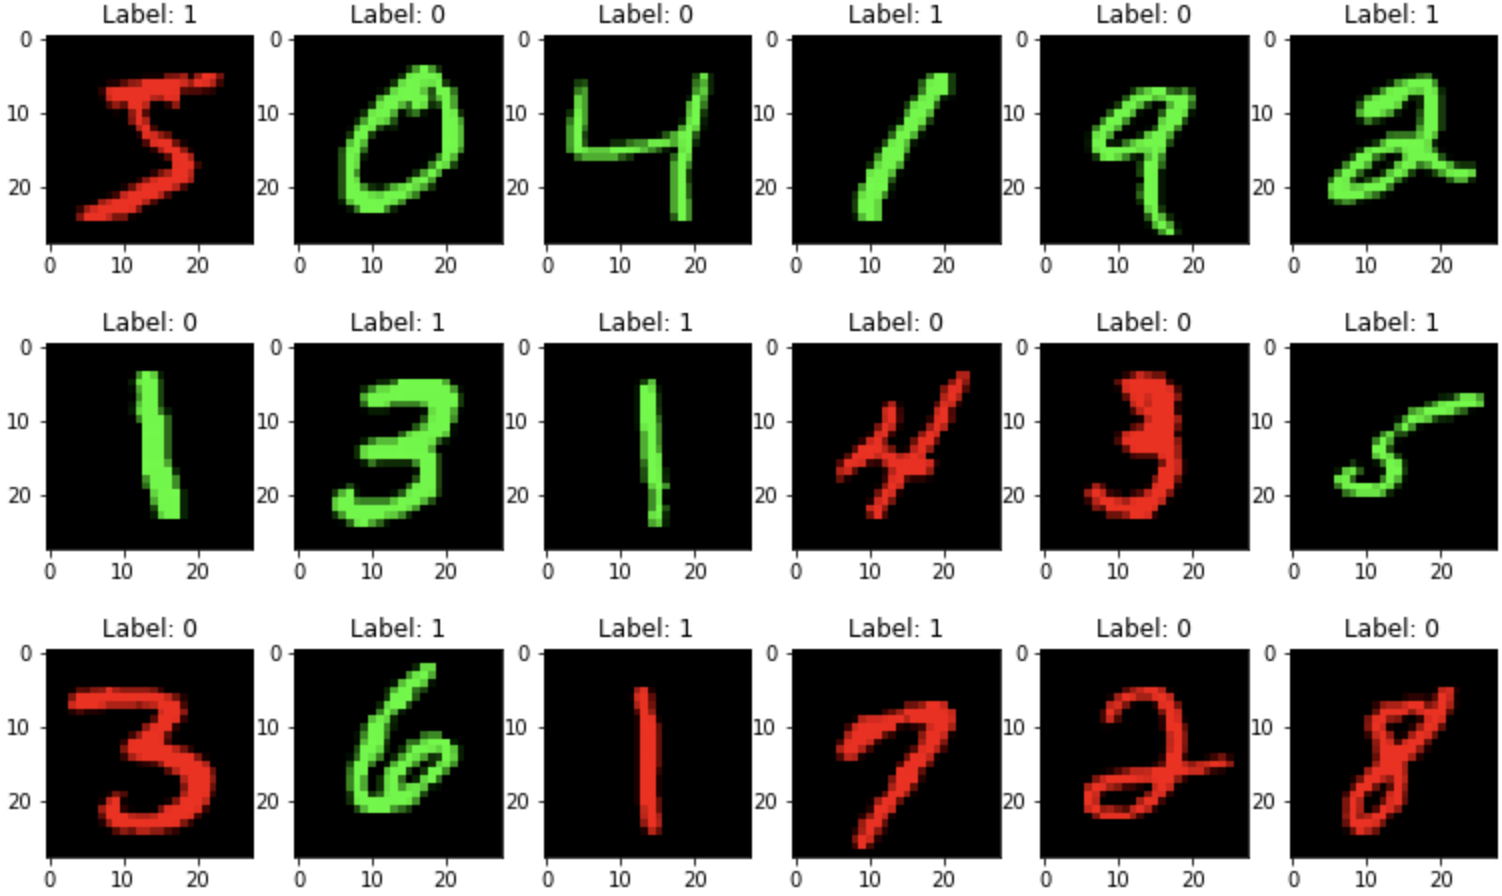

# Colored MNIST数据集

In [1]:
import os

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils


def color_grayscale_arr(arr, red=True):
    """Converts grayscale image to either red or green"""
    assert arr.ndim == 2
    dtype = arr.dtype
    h, w = arr.shape
    arr = np.reshape(arr, [h, w, 1])
    if red:
        arr = np.concatenate([arr,
                              np.zeros((h, w, 2), dtype=dtype)], axis=2)
    else:
        arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),
                              arr,
                              np.zeros((h, w, 1), dtype=dtype)], axis=2)
    return arr


class ColoredMNIST(datasets.VisionDataset):
    """
  Colored MNIST dataset for testing IRM. Prepared using procedure from https://arxiv.org/pdf/1907.02893.pdf

  Args:
    root (string): Root directory of dataset where ``ColoredMNIST/*.pt`` will exist.
    env (string): Which environment to load. Must be 1 of 'train1', 'train2', 'test', or 'all_train'.
    transform (callable, optional): A function/transform that  takes in an PIL image
      and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (callable, optional): A function/transform that takes in the
      target and transforms it.
  """

    def __init__(self, root='./data', env='train1', transform=None, target_transform=None):
        super(ColoredMNIST, self).__init__(root, transform=transform,
                                           target_transform=target_transform)

        self.prepare_colored_mnist()
        if env in ['train1', 'train2', 'test']:
            self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', env) + '.pt')
        elif env == 'all_train':
            self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', 'train1.pt')) + \
                                     torch.load(os.path.join(self.root, 'ColoredMNIST', 'train2.pt'))
        else:
            raise RuntimeError(f'{env} env unknown. Valid envs are train1, train2, test, and all_train')

    def __getitem__(self, index):
        """
    Args:
        index (int): Index

    Returns:
        tuple: (image, target) where target is index of the target class.
    """
        img, target = self.data_label_tuples[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data_label_tuples)

    def prepare_colored_mnist(self):
        colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
        if os.path.exists(os.path.join(colored_mnist_dir, 'train1.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'train2.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'test.pt')):
            print('Colored MNIST dataset already exists')
            return

        print('Preparing Colored MNIST')
        train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True)

        train1_set = []
        train2_set = []
        test_set = []
        for idx, (im, label) in enumerate(train_mnist):
            if idx % 10000 == 0:
                print(f'Converting image {idx}/{len(train_mnist)}')
            im_array = np.array(im)

            # Assign a binary label y to the image based on the digit
            binary_label = 0 if label < 5 else 1

            # Flip label with 25% probability
            if np.random.uniform() < 0.25:
                binary_label = binary_label ^ 1

            # Color the image either red or green according to its possibly flipped label
            color_red = binary_label == 0

            # Flip the color with a probability e that depends on the environment
            if idx < 20000:
                # 20% in the first training environment
                if np.random.uniform() < 0.2:
                    color_red = not color_red
            elif idx < 40000:
                # 10% in the first training environment
                if np.random.uniform() < 0.1:
                    color_red = not color_red
            else:
                # 90% in the test environment
                if np.random.uniform() < 0.9:
                    color_red = not color_red

            colored_arr = color_grayscale_arr(im_array, red=color_red)

            if idx < 20000:
                train1_set.append((Image.fromarray(colored_arr), binary_label))
            elif idx < 40000:
                train2_set.append((Image.fromarray(colored_arr), binary_label))
            else:
                test_set.append((Image.fromarray(colored_arr), binary_label))

            # Debug
            # print('original label', type(label), label)
            # print('binary label', binary_label)
            # print('assigned color', 'red' if color_red else 'green')
            # plt.imshow(colored_arr)
            # plt.show()
            # break

        dataset_utils.makedir_exist_ok(colored_mnist_dir)
        torch.save(train1_set, os.path.join(colored_mnist_dir, 'train1.pt'))
        torch.save(train2_set, os.path.join(colored_mnist_dir, 'train2.pt'))
        torch.save(test_set, os.path.join(colored_mnist_dir, 'test.pt'))

# ▶︎▶︎▶︎基础部分

### 1. 设计ColoredMNIST数据二分类的因果图，合理即可。并基于后门准则，推导𝑃(𝑦|𝑑𝑜(𝑥)) 【提示：因果图可以为E->X, E->Y, X->Y, E为环境，比如颜色】

### 2. 在ColoredMNIST数据上实现基于后门准则的因果推理算法，训练神经网络，提升模型预测准确度。

# 1. 读取数据

In [2]:
########################################▶︎###############################
###一下是一个简单的读取Colored MNIST例子，请进一步完善。可以进行数据预处理等操作。###
#######################################################################
import numpy as np
import random


class ColoredMNIST(datasets.VisionDataset):

    def __init__(self, root='./data', transform=None, target_transform=None, train_test='train'):
        super(ColoredMNIST, self).__init__(root, transform=transform,
                                           target_transform=target_transform)
        
        
        if train_test == 'train':
            self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', 'train1.pt')) + \
                                     torch.load(os.path.join(self.root, 'ColoredMNIST', 'train2.pt'))
        elif train_test == 'test':
            self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', 'test.pt'))
        else :
            raise RuntimeError('Unable to load unknown datasets')
        

    def __getitem__(self, index):
        img, target = self.data_label_tuples[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data_label_tuples)

# 2. 定义模型

# 3. 训练模型并输出测试结果

# ▶︎▶︎▶︎提高部分

### 1. 将上述过程中用到的神经网络替换为SNN，可使用SNNTorch库，并研究方法提高其泛化性能；


### 2. 将上述过程中用到的神经网络替换为Memristor，可使用MemTorch库，并研究方法提高其泛化性能；

### 3. 进一步研究因果推理，因果表示学习方法，甚至不限于这类方法，提高卷积神经网络在此数据集上的性能。

/home/ljy/anaconda3/envs/ox/lib/python3.8/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/home/ljy/anaconda3/envs/ox/lib/python3.8/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch: 0, [iter: 0 / all 625], err_s_label: 0.6451382637023926, err_s_domain: 0.7885119318962097, err_t_domain: 0.6498783826828003
epoch: 0, [iter: 25 / all 625], err_s_label: 0.5805034041404724, err_s_domain: 0.6989049911499023, err_t_domain: 0.7003971338272095
epoch: 0, [iter: 50 / all 625], err_s_label: 0.42481833696365356, err_s_domain: 0.6834936738014221, err_t_domain: 0.6925731301307678
epoch: 0, [iter: 75 / all 625], err_s_label: 0.21021929383277893, err_s_domain: 0.7126770615577698, err_t_domain: 0.6921555399894714
epoch: 0, [iter: 100 / all 625], err_s_label: 0.23751211166381836, err_s_domain: 0.6944047212600708, err_t_domain: 0.6952617764472961
epoch: 0, [iter: 125 / all 625], err_s_label: 0.1880224198102951, err_s_domain: 0.6877055168151855, err_t_domain: 0.7036781907081604
epoch: 0, [iter: 150 / all 625], err_s_label: 0.3117755055427551, err_s_domain: 0.6897990703582764, err_t_domain: 0.7015137672424316
epoch: 0, [iter: 175 / all 625], err_s_label: 0.14114908874034882, err_

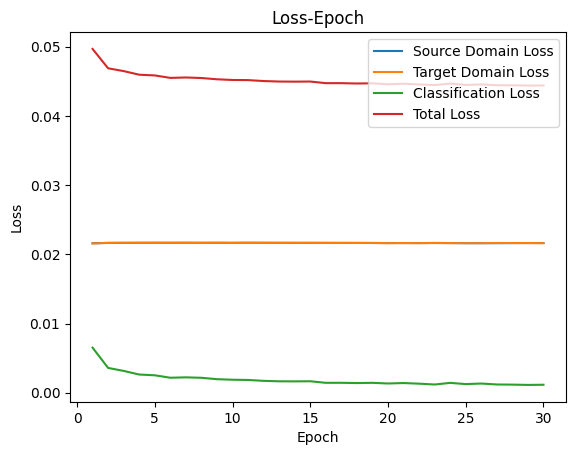

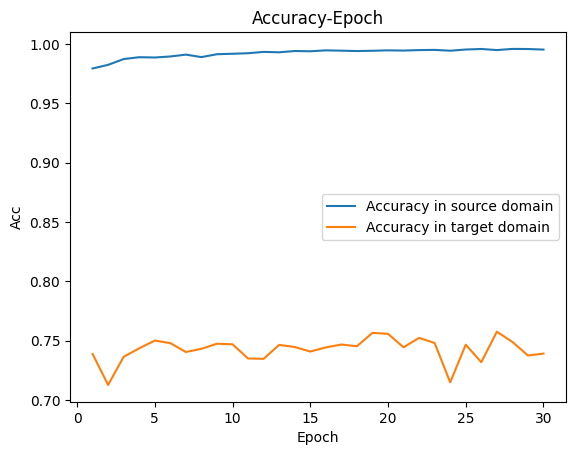

In [19]:
## Domain-Adversarial Neutal Network

from torch.autograd import Function
import torch.nn as nn
import random
import os
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms
import numpy as np



class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

## Define CNN Model with Domain Classifier and Class Classifier

class CNNModel(nn.Module):

    def __init__(self):
        super(CNNModel, self).__init__()
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(3, 64, kernel_size=5))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(64))
        self.feature.add_module('f_pool1', nn.MaxPool2d(2))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_conv2', nn.Conv2d(64, 50, kernel_size=5))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(50))
        self.feature.add_module('f_drop1', nn.Dropout2d())
        self.feature.add_module('f_pool2', nn.MaxPool2d(2))
        self.feature.add_module('f_relu2', nn.ReLU(True))

        self.class_classifier = nn.Sequential()
        self.class_classifier.add_module('c_fc1', nn.Linear(50 * 4 * 4, 100))
        self.class_classifier.add_module('c_bn1', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu1', nn.ReLU(True))
        self.class_classifier.add_module('c_drop1', nn.Dropout2d())
        self.class_classifier.add_module('c_fc2', nn.Linear(100, 100))
        self.class_classifier.add_module('c_bn2', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu2', nn.ReLU(True))
        self.class_classifier.add_module('c_fc3', nn.Linear(100, 2))
        self.class_classifier.add_module('c_softmax', nn.LogSoftmax())

        self.domain_classifier = nn.Sequential()
        self.domain_classifier.add_module('d_fc1', nn.Linear(50 * 4 * 4, 100))
        self.domain_classifier.add_module('d_bn1', nn.BatchNorm1d(100))
        self.domain_classifier.add_module('d_relu1', nn.ReLU(True))
        self.domain_classifier.add_module('d_fc2', nn.Linear(100, 2))
        self.domain_classifier.add_module('d_softmax', nn.LogSoftmax(dim=1))

    def forward(self, input_data, alpha):
        input_data = input_data.expand(input_data.data.shape[0], 3, 28, 28)
        feature = self.feature(input_data)
        feature = feature.view(-1, 50 * 4 * 4)
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = self.class_classifier(feature)
        domain_output = self.domain_classifier(reverse_feature)

        return class_output, domain_output

## Model Test Function

def test(dataloader, source_or_target, epoch, model_root):

    cuda = True
    cudnn.benchmark = True
    batch_size = 32
    image_size = 28
    alpha = 0

    """ training """

    my_net = torch.load(os.path.join(
        model_root, 'mnist_mnistm_model_epoch_' + str(epoch) + '.pth'
    ))
    my_net = my_net.eval()

    if cuda:
        my_net = my_net.cuda()

    len_dataloader = len(dataloader)
    data_target_iter = iter(dataloader)

    n_total = 0
    n_correct = 0

    for i in range(len_dataloader):

        # test model using target data
        (t_img, t_label) = next(data_target_iter)

        batch_size = len(t_label)

        if cuda:
            t_img = t_img.cuda()
            t_label = t_label.cuda()


        class_output, _ = my_net(input_data=t_img, alpha=alpha)
        pred = class_output.data.max(1, keepdim=True)[1]
        n_correct += pred.eq(t_label.data.view_as(pred)).cpu().sum()
        n_total += batch_size


    accu = n_correct.data.numpy() * 1.0 / n_total

    print ('epoch: {}, accuracy of the {} dataset: {}'.format(epoch, source_or_target, accu))
    return accu

## Model Train & Test

cuda = True
cudnn.benchmark = True
lr = 1e-3
batch_size = 32
image_size = 28
n_epoch = 30


model_root = os.path.join('.', 'models')

manual_seed = random.randint(1, 10000)
random.seed(manual_seed)
torch.manual_seed(manual_seed)

# load model

my_net = CNNModel()

# setup optimizer

optimizer = optim.Adam(my_net.parameters(), lr=lr)

loss_class = torch.nn.CrossEntropyLoss()
loss_domain = torch.nn.CrossEntropyLoss()

if cuda:
    my_net = my_net.cuda()
    loss_class = loss_class.cuda()
    loss_domain = loss_domain.cuda()
    
for p in my_net.parameters():
    p.requires_grad = True

# Turn mnist data from one channel to three channels
img_transform_source = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.cat([x, x, x])),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

lbl_transform_source = transforms.Compose([
    transforms.Lambda(lambda x: 0 if x < 5 else 1)
])

img_transform_target = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

dataset_source = datasets.MNIST(root='./data/MNIST/', train=True, transform=img_transform_source, 
                                    target_transform=lbl_transform_source, download=False)
#dataset_source = ColoredMNIST(transform=img_transform_source, train_test='train')
dataset_target = ColoredMNIST(transform=img_transform_target, train_test='test')

dataloader_source = torch.utils.data.DataLoader(dataset_source,
                        batch_size=batch_size, shuffle=True)
dataloader_target = torch.utils.data.DataLoader(dataset_target, 
                        batch_size=batch_size, shuffle=False)

err_s_domain_list = []
err_t_domain_list = []
err_s_label_list = []
err_list = []
acc_source_list = []
acc_target_list = []

for epoch in range(n_epoch):

    len_dataloader = min(len(dataloader_source), len(dataloader_target))
    data_source_iter = iter(dataloader_source)
    data_target_iter = iter(dataloader_target)

    err_s_domain_total = 0
    err_t_domain_total = 0
    err_s_label_total = 0
    err_total = 0
    
    for i in range(len_dataloader):

        p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # training model using source data
        (s_img, s_label) = next(data_source_iter)

        my_net.zero_grad()
        batch_size = len(s_label)

        domain_label = torch.zeros(batch_size).long()

        if cuda:
            s_img = s_img.cuda()
            s_label = s_label.cuda()
            domain_label = domain_label.cuda()

        class_output, domain_output = my_net(input_data=s_img, alpha=alpha)
        err_s_label = loss_class(class_output, s_label)
        err_s_domain = loss_domain(domain_output, domain_label)

        # training model using target data
        (t_img, _) = next(data_target_iter)

        batch_size = len(t_img)

        domain_label = torch.ones(batch_size).long()

        if cuda:
            t_img = t_img.cuda()
            domain_label = domain_label.cuda()

        _, domain_output = my_net(input_data=t_img, alpha=alpha)
        err_t_domain = loss_domain(domain_output, domain_label)

        err = err_t_domain + err_s_domain + err_s_label

        err_s_domain_total += err_s_domain.sum().item()
        err_t_domain_total += err_t_domain.sum().item()
        err_s_label_total += err_s_label.sum().item()
        err_total += err.sum().item()

        err.backward()
        optimizer.step()

        if i % 25 == 0:
            print ('epoch: {}, [iter: {} / all {}], err_s_label: {}, err_s_domain: {}, err_t_domain: {}' 
                    .format(epoch, i, len_dataloader, err_s_label.cpu().data.numpy(),
                        err_s_domain.cpu().data.numpy(), err_t_domain.cpu().data.numpy()))

    err_s_domain_list.append(err_s_domain_total/len_dataloader/batch_size)
    err_t_domain_list.append(err_t_domain_total/len_dataloader/batch_size)
    err_s_label_list.append(err_s_label_total/len_dataloader/batch_size)
    err_list.append(err_total/len_dataloader/batch_size)

    torch.save(my_net, '{}/mnist_mnistm_model_epoch_{}.pth'.format(model_root, epoch))
    
    acc_source = test(dataloader_source, source_or_target='source', epoch=epoch, model_root=model_root)
    acc_target = test(dataloader_target, source_or_target='target', epoch=epoch, model_root=model_root)
    acc_source_list.append(acc_source)
    acc_target_list.append(acc_target)

# Plot the loss and acc versus epoch
plt.title('Loss-Epoch')  
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
epoch_list = list(range(1,n_epoch+1))
plt.plot(epoch_list, err_s_domain_list)
plt.plot(epoch_list, err_t_domain_list)
plt.plot(epoch_list, err_s_label_list)
plt.plot(epoch_list, err_list)
plt.legend(['Source Domain Loss', 'Target Domain Loss', 'Classification Loss', 'Total Loss'])
plt.savefig('./figure/Epoch-Loss.jpg')
plt.show()

plt.title('Accuracy-Epoch')  
plt.xlabel('Epoch') 
plt.ylabel('Acc')
plt.plot(epoch_list, acc_source_list)
plt.plot(epoch_list, acc_target_list)
plt.legend(['Accuracy in source domain', 'Accuracy in target domain'])
plt.savefig('./figure/Epoch-Acc.jpg')
plt.show()